# Generative Adversarial Networks
In this assignment, you’ll get hands-on experience coding and training GANs. This assignment is
divided into two parts: in the first part, we will implement a specific type of GAN designed to
process images, called a Deep Convolutional GAN (DCGAN). We’ll train the DCGAN to generate
emojis from samples of random noise. In the second part, we will apply some methods that researchers have suggested to "stablize" the training process of GANs and then train our DCGAN again.

**Note:** Please attempt this assignment on Google Colab, since that will speed up the training process.

In [1]:
# Uncomment and run these in Colab
%tensorflow_version 1.x
!pip install --upgrade opencv-python==3.4.2.17
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from keras.preprocessing import image as k_image
from keras.utils.generic_utils import Progbar
from keras.initializers import RandomNormal
import random

TensorFlow 1.x selected.
     |████████████████████████████████| 25.0MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import shutil
import os
os.mkdir('DLAS5')
shutil.copy2('drive/My Drive/DLAS5/filtered_emojis.zip', 'DLAS5/filtered_emojis.zip')

'DLAS5/filtered_emojis.zip'

In [0]:
%cd ../content/DLAS5
#os.mkdir("full_emojis")
#%cd ./filtered_emojis
!unzip 'filtered_emojis.zip'

In [0]:
ROLLNUMBER = 20100064
BATCH_SIZE = 128
IMAGE_SHAPE = [64,64]
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 2000
# Use this to prefix all your paths when reading/writing data to drive.
#BASE_DIR = ''
BASE_DIR = '/content/drive/My Drive/DLAS5'

- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

## PART 1: Deep Convolutional GAN (DCGAN)
For the first part of this assignment, we will implement a Deep Convolutional GAN (DCGAN).
A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator. To implement the DCGAN, we
need to specify three things: 1) the generator, 2) the discriminator, and 3) the training procedure.
We will develop each of these three components in the following subsections.

In [0]:
## Helper Functions
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

def remove_transparency(source, background_color):
    source_img = source[:, :, :3]
    source_mask = source[:, :, 3]  * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)
    background_mask = 1.0 - source_mask
    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)
    return cv2.cvtColor(np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0)),cv2.COLOR_BGR2RGB)

def load_data():
    base_dir = 'filtered_emojis/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

### Implementing the Discriminator of the DCGAN
The discriminator in this DCGAN is a convolutional neural network that has the following architecture:
<br>
![DCGAN Discriminator](DCGAN_disc.png)
<br>

**Some Important points**:
- Pass in the following arguments in your Convolutional Layers: padding='same',use_bias=False
- After the last convolutional layer, Flatten the output and then add the final dense layer for prediction
- Use kernel_size of (4,4), except the last one -- You may change this ((4,4) one) but don't reduce it too much
- Reduce the spatial dimension by a factor of 2 after each convolution, except the last one.
- Use LeakyRelu and BatchNormalization after each convolution

Implement the discriminator in the cell below:

In [0]:
def build_discriminator():
    input1 = Input(shape = (64,64,3))
    conv31 = Conv2D(64,(4,4),padding='same',strides=(2,2),use_bias=False)(input1)
    leaky1 = LeakyReLU(alpha = 0.3)(conv31)
    conv32 = Conv2D(128,(4,4),padding='same',strides=(2,2),use_bias=False)(leaky1)
    batch1 =  BatchNormalization()(conv32)
    leaky2 = LeakyReLU(alpha = 0.3)(batch1)
    conv33 = Conv2D(256,(4,4),padding='same',strides=(2,2),use_bias=False)(leaky2)
    batch2 =  BatchNormalization()(conv33)
    leaky3 = LeakyReLU(alpha = 0.3)(batch2)
    conv34 = Conv2D(512,(4,4),padding='same',strides=(2,2),use_bias=False)(leaky3)
    batch3 =  BatchNormalization()(conv34)
    leaky4 = LeakyReLU(alpha = 0.3)(batch3)
    conv35 = Conv2D(1,(2,2),padding='same',use_bias=False)(leaky3)
    flat1 = Flatten()(conv35)
    output = Dense(1,activation = 'sigmoid')(flat1)
    model_disc = Model(inputs=input1,outputs=output)

    adam = Adam(lr=0.0001)
    model_disc.compile(loss= 'binary_crossentropy',optimizer=adam, metrics=['accuracy'])

    return model_disc


### Implementing the generator of DCGAN
Now, we will implement the generator of the DCGAN, which consists of a sequence of transpose
convolutional layers that progressively upsample the input noise sample to generate a fake image.
The generator has the following architecture:
<br>
![DCGAN Generator](DCGAN_gen.png)

**Some important points:**
- Pass in use_bias=False,padding='same' in your convolutional layers.
- All intermediate convolutional layers will have relu activation except the last one, which will have tanh.
- All other properties can be inferred from the above diagram

Implement the generator in the cell below

In [0]:
def build_generator():
  input1 = Input(shape=(NOISE_DIM,))
  dense1 = Dense(4*4*1024)(input1)
  reshape = Reshape((4,4,1024))(dense1)
  tconv1 = Conv2DTranspose(512,(5,5),use_bias=False,padding='same',strides=(2,2),activation='relu')(reshape)
  batch1 = BatchNormalization()(tconv1)

  tconv2 = Conv2DTranspose(256,(5,5),use_bias=False,padding='same',strides=(2,2),activation='relu')(batch1)
  batch2 = BatchNormalization()(tconv2)

  tconv3 = Conv2DTranspose(128,(5,5),use_bias=False,padding='same',strides=(2,2),activation='relu')(batch2)
  batch3 = BatchNormalization()(tconv3)

  tconv4 = Conv2DTranspose(3,(5,5),use_bias=False,padding='same',strides=(2,2),activation='tanh')(batch3)
  
  model_gen = Model(inputs=input1,outputs=tconv4)
  adam = Adam(lr=0.0001)
  model_gen.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

  return model_gen
    

### DCGAN Training Loop
Next, you will implement the training loop for the DCGAN. A DCGAN is simply a GAN with a
specific type of generator and discriminator; thus, we train it in exactly the same way as a standard
GAN. The pseudo-code for the training procedure is shown below.

**Algorithm:**    
1. Draw m training examples {x<sup>(1)</sup>,...,x<sup>(m)</sup>} from the data distribution p<sub>data</sub>.
2. Draw m noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
3. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
4. Compute discriminator's loss on real images and fake images batches and then update the parameters.
5. Draw m NEW noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
6. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
7. Freeze the discriminator.
8. Compute generator's loss then update the parameters.
9. Unfreeze the discriminator.

Before we move to writing the training loop, we will need to create a "combined" model that will attach the discriminator over the generator. This model will be used to train the generator as the discriminator will act as an adversary for the generator and force it to generate realistic images.

In this function below you need to create a model that:
- Takes noise z as input (Matching the noise dimensions defined at the top of the notebook)
- Gets a fake image generated from the generator using this noise z
- "Freezes" the discriminator (Setting all layers of the discriminator as untrainable)
- Outputs the output of the discriminator based on the input z.

Remember to compile the model before returning it.

In [0]:
def build_gan(gen,disc):
  input1 = Input(shape = (NOISE_DIM,))
  img = gen(input1)

  for l in disc.layers:
    l.trainable = False;

  output1 = disc(img)
  model_dcgan = Model(inputs=input1,outputs=output1)

  model_dcgan.compile(loss='binary_crossentropy',optimizer= Adam(lr=0.001), metrics=['accuracy'])
  return model_dcgan


Write your training loop in the cell bellow. Some important points to keep in mind:
- You need to compile the discriminator after creating an instance using build_discriminator()
- Use the provided load_data() function to well... load the data. You can choose between generating Windows or Apple emojis
- The entire data will be loaded as it is small enough to fit into memory (Finally no data generators, right?) BUT you still need to loop over the data in batches. Starter code is provided to you.
- To train your models, we won't make use of <code>fit</code> instead we will use <code>train_on_batch</code> to train our model over batches. This method will return your model's loss over a particular batch, which you will use to output and store your history of losses.
- Additionally, we will be generating samples after some epochs and storing the result on disk. The code is provided to do this.

In [0]:
def save_samples(generated_images,step,save_at="samples1/"):
    sample_image = create_image_grid(generated_images)
    img = k_image.array_to_img(sample_image)
    img.save(os.path.join(BASE_DIR,save_at, 'generated_image_' + str(step) + '.png'))

In [0]:
def gan_training_loop(intervals=200):
    # Setup Models here
    discriminator = build_discriminator()
    generator = build_generator()
    dcgan = build_gan(generator,discriminator)

    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here
            training_samples = X_train[index:index+BATCH_SIZE]
            noise_samples  = sample_noise()
              #generate imgs and
            generated_imgs = generator.predict(noise_samples)

            labels_real = np.ones((BATCH_SIZE,), dtype=int)
            labels_fake = np.zeros((BATCH_SIZE,), dtype=int)
            hist_disc_real = discriminator.train_on_batch(training_samples,labels_real)
            hist_disc_fake = discriminator.train_on_batch(generated_imgs,labels_fake)

            if not (e % intervals):
                save_samples(generated_imgs,e,save_at='samples_uns')     
            
            disc_loss = (hist_disc_real[0] + hist_disc_fake) * 0.5
            epoch_disc_loss.append(disc_loss)
            
            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            # Unfreeze after your call to train_on_batch
            for l in discriminator.layers:
              l.trainable = False

            noise_gen = sample_noise()
            labels_gen = np.ones((BATCH_SIZE,), dtype=int)
            hist_gen = dcgan.train_on_batch(noise_gen,labels_gen)

            for l in discriminator.layers:
              l.trainable = True
      
            gen_loss = hist_gen[0]
            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
            # Save weights here
            discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_uns'),True)
            generator.save_weights(os.path.join(BASE_DIR,'generator_uns'),True)

        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

### Training the GAN
We will train a DCGAN to generate fake Apple emojis. 1 epoch should take about 15 seconds on Google Colab.

Train your DCGAN in the below cell

In [18]:
%pwd

'/content/DLAS5'

In [14]:
all_disc_loss,all_gen_loss = gan_training_loop()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5/5 [==============================] - 13s 3s/step
Epoch: 1 | Discriminator Loss: 0.427959 | Generator Loss: 0.275749
5/5 [==============================] - 2s 462ms/step
Epoch: 2 | Discriminator Loss: 0.310509 | Generator Loss: 0.003468
5/5 [==============================] - 2s 467ms/step
Epoch: 3 | Discriminator Loss: 0.253819 | Generator Loss: 0.007104
5/5 [==============================] - 2s 459ms/step
Epoch: 4 | Discriminator Loss: 0.250140 | Generator Loss: 0.004723
5/5 [==============================] - 2s 465ms/step
Epoch: 5 | Discriminator Loss: 0.250091 | Generator Loss: 0.001790
5/5 [==============================] - 2s 464ms/step
Epoch: 6 | Discriminator Loss: 0.250101 | Generator Loss: 0.000424
5/5 [==============================] - 2s 467ms/step
Epoch: 7 | Discriminator Loss: 0.250136 | Generator Loss: 0.000191
5/5 [==============================] - 2s 469ms/step
Epoch: 8 | Discriminator Loss: 0.250184 | Generator Loss: 0.000122
5/5 [==============================] - 2s 

### Generating Samples and Analysis

- Plot your discriminator and generator losses and explain how it represents the MiniMax game in play, and comment on the trends you observe.
- Generate random 5 noise samples and their corresponding fake images.
- Mention if you observe any failure modes
- **BONUS (5%):** Try generating some good samples, and try interpolating the input noise samples (Vector Arithmetic) to see if the results are as expected.

In [0]:
def plot_loss(gen_loss,disc_loss):
    plt.plot(gen_loss)
    plt.plot(disc_loss)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

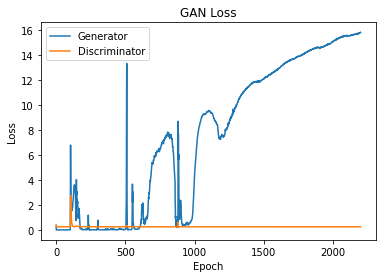

In [17]:
plot_loss(all_gen_loss,all_disc_loss)

#####Loss plot Analysis

*  The GAN loss is very high and the losses dont converge, indicating convergence failure. The generator and discriminator are unable to reach a balance. Here, the performance of the generator is poor and it is unable to fool the discriminator.
*   The generator is very unstable as the loss keeps decreasing and increasing sharply over epochs.
<li> At each step, the generator wants to maximize its output but the discriminator wants to minimize its loss. They compete against one another, but need to find a balance where the generator is able to fool the discriminator into beleiving that the fake generated images are real. In the loss plot, the loss variation shows that its able to fool the discriminator for a while but then the discriminator learns and is again able to correctly classify fake images, increasing the generator's loss.




In [0]:
generator = build_generator()
generator.load_weights('/content/drive/My Drive/DLAS5/generator_uns')

In [0]:
for i in range(0,5):
  noise = sample_noise()
  grid = generator.predict(noise)
  save_samples(grid,i,save_at='final_part1')


#### Failure Modes observed in generated samples
Mode Collapse: The images generated are near duplicates. All the samples generated from the trained model are identical, which means the generator fails to learn new features.<br> 
Convergence failure: The generator loss increases and the discriminator overpowers the generator. The generator is unable to learn well, as shown by the samples generated. Hardly any emoji is distinguishable.


In [14]:
%pwd

'/content'

## PART 2: Stablizing GANs

In the first part, we trained our GAN using the standard methods proposed initially. In this part we will tweak our models and our training loop based on suggestions that deep learning researchers have come up with through their experiences. We will see if we encountered into typical problems faced while training GANs and see if these proposed methods improve our GANs and resolve issuse previously faced.

We have already implemented a GAN based on the recommendations made by Alec Radford, et al. in the 2015 paper titled [“Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.”](https://arxiv.org/abs/1511.06434)



We have:
1. Downsampled using strided convolutions
2. Upsampled using strided convolutions
3. Used LeakyReLu in our discriminator, and ReLu in the generator and Tanh for the output of the generator.
4. Used BatchNormalization in both the discriminator and generator.

In addition to these, we will also make use of some more tips from the aforementioned paper, as well as tips from Soumith Chintala, who is one of the co-authors of the DCGAN paper in his [NIPS presentation](https://www.youtube.com/watch?v=X1mUN6dD8uE)

### Modifications in the Models

Here are some suggested modifications in the generator and discriminator models:

- Use LeakyReLu in BOTH the generator and discriminator
- Use Gaussian Weight initialization with mean=0 and std = 0.02. (Use the imported RandomNormal function to get weights and pass it in as the kernel_initializer argument in a convolutional layer)
- Use Adam optimizer

Make these modifications in your generator and discriminator models.

In [0]:
def build_discriminator_mod():
    weight_init = RandomNormal(mean=0, stddev=0.02)

    input1 = Input(shape = (64,64,3))
    conv31 = Conv2D(64,(4,4),padding='same',strides=(2,2),use_bias=False,
                    kernel_initializer=weight_init)(input1)
    leaky1 = LeakyReLU(alpha = 0.3)(conv31)
    conv32 = Conv2D(128,(4,4),padding='same',strides=(2,2),use_bias=False,
                    kernel_initializer=weight_init)(leaky1)
    batch1 = BatchNormalization()(conv32)
    leaky2 = LeakyReLU(alpha = 0.3)(batch1)
    conv33 = Conv2D(256,(4,4),padding='same',strides=(2,2),use_bias=False,
                    kernel_initializer=weight_init)(leaky2)
    batch2 = BatchNormalization()(conv33)
    leaky3 = LeakyReLU(alpha = 0.3)(batch2)
    conv34 = Conv2D(512,(4,4),padding='same',strides=(2,2),use_bias=False,
                    kernel_initializer=weight_init)(leaky3)
    batch3 = BatchNormalization()(conv34)
    leaky4 = LeakyReLU(alpha = 0.3)(batch3)
    conv35 = Conv2D(1,(2,2),padding='same',use_bias=False,
                    kernel_initializer=weight_init)(leaky3)
    flat1 = Flatten()(conv35)
    output = Dense(1,activation = 'sigmoid')(flat1)
    model_disc = Model(inputs=input1,outputs=output)

    adam = Adam(lr=0.0001)
    model_disc.compile(loss= 'binary_crossentropy',optimizer=adam, metrics=['accuracy'])

    return model_disc

In [0]:
def build_generator_mod():
  weight_init = RandomNormal(mean=0, stddev=0.02)

  input1 = Input(shape=(NOISE_DIM,))
  dense1 = Dense(4*4*1024)(input1)
  reshape = Reshape((4,4,1024))(dense1)

  tconv1 = Conv2DTranspose(512,(5,5),use_bias=False,padding='same',strides=(2,2),
                           kernel_initializer=weight_init)(reshape)
  batch1 = BatchNormalization()(tconv1)
  leaky1 = LeakyReLU(alpha = 0.3)(batch1)

  tconv2 = Conv2DTranspose(256,(5,5),use_bias=False,padding='same',strides=(2,2),
                           kernel_initializer=weight_init)(leaky1)
  batch2 = BatchNormalization()(tconv2)
  leaky2 = LeakyReLU(alpha = 0.3)(batch2)

  tconv3 = Conv2DTranspose(128,(5,5),use_bias=False,padding='same',strides=(2,2),
                           kernel_initializer=weight_init)(leaky2)
  batch3 = BatchNormalization()(tconv3)
  leaky3 = LeakyReLU(alpha = 0.3)(batch3)

  tconv4 = Conv2DTranspose(3,(5,5),use_bias=False,padding='same',strides=(2,2),activation='tanh',
                           kernel_initializer=weight_init)(leaky3)
  
  model_gen = Model(inputs=input1,outputs=tconv4)
  adam = Adam(lr=0.001)
  model_gen.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

  return model_gen
    

### Scale Images to the Range [-1,1]
We already know that normalizing images improves training for any model. We will scale our images in the range [-1,1] since we are using a tanh activation in our generator. This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.    
Implement the following function to normalize a numpy array containing images. **Note:** The images will be in the range [0,255]

In [0]:
def normalize(images):
  norm_images = (images - 127.5) / 127.5
  return norm_images

### Use Gaussian Latent Space
Previously we have been using a uniform distribution to sample a latent space as recommended in the DCGAN paper, but more recently researchers suggest to use a Standard Gaussian distribution to sample the latent space. Modify the <code>sample_noise</code> function to sample fomr a Gaussian distribution.

In [0]:
def sample_noise_mod():
    return np.reshape(np.random.normal(0,1,(NOISE_DIM*BATCH_SIZE)),(BATCH_SIZE,NOISE_DIM))

### Use Label Smoothing
Normally, we use hard labels 1s and 0s to train our GANs. Researchers have suggested to smooth labels and use "soft" labels . This is said to have a "regularizing" effect on the training.

#### Real Label Smoothing
For Real labels, i.e. 1s, we will smooth the labels uniformly between [0.7,1.2]. Use np.random.random for this.

In [0]:
def smooth_real_labels(y):
  shape = y.shape
  return y - 0.3 + (np.random.random(y.shape) * 0.5)

#### Fake Label Smoothing

In [0]:
def smooth_fake_labels(y):
  return y + np.random.random(y.shape) * 0.3

We will make use of these functions later in our training loop.

### Train Discriminator with Real and Fake Images separately
Previously we were combining our fake and real images batches and doing one update to our discriminator. Researchers suggest that the best practice is to train our discriminator in two updates, one for the real images and one for the fake images.

### Flip some labels randomly while training the Generator
Soumith Chintala also suggests that in practice, ocassionally flipping the labels of the generator may help (Swapping Real and Fake)

In [0]:
def flip_labels(y, prob=0.05):
  n_choose = int(prob * y.shape[0])
  flip_l = np.random.choice([i for i in range(y.shape[0])], size=n_choose)
  y[flip_l] = 1 - y[flip_l]
  return y

### Modified Training Loop

Incorporate the above mentioned suggestions in your training process. You don't have to apply all of them. See which combination works best for you. Mention the methods you made use of.

In [0]:
def gan_training_loop_mod(intervals=200):
    # Setup Models here
    discriminator = build_discriminator_mod()
    generator = build_generator_mod()
    dcgan = build_gan(generator,discriminator)

    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            training_samples = normalize(X_train[index:index+BATCH_SIZE])
            noise_samples  = sample_noise_mod()
            generated_imgs = generator.predict(noise_samples)

            labels_real = smooth_real_labels(np.ones((BATCH_SIZE,), dtype=int))
            labels_fake = smooth_fake_labels(np.zeros((BATCH_SIZE,), dtype=int))

            # labels_real = flip_labels(np.ones((BATCH_SIZE,), dtype=int))
            # labels_fake = flip_labels(np.zeros((BATCH_SIZE,), dtype=int))
            hist_disc_real = discriminator.train_on_batch(training_samples,labels_real)
            hist_disc_fake = discriminator.train_on_batch(generated_imgs,labels_fake)

            # Write your code here
            if not (e % intervals):
                save_samples(generated_imgs,e,save_at='samples_mod10')
              
            # If you are training the discriminator in two updates, uncomment this
            disc_loss = (hist_disc_fake[0] + hist_disc_real[0]) * 0.5
            epoch_disc_loss.append(disc_loss)

            for l in discriminator.layers:
              l.trainable = False

            noise_gen = sample_noise_mod()
            #labels_flip_gen = flip_labels(np.ones((BATCH_SIZE,), dtype=int))
            labels_real_gen = flip_labels((np.ones((BATCH_SIZE,), dtype=int)))
            hist_gen = dcgan.train_on_batch(noise_gen,labels_real_gen)

            for l in discriminator.layers:
              l.trainable = True
      
            gen_loss = hist_gen[0]
            epoch_gen_loss.append(gen_loss)
            
            progress_bar.update(i+1)
        if not (e%intervals):
            discriminator.save_weights(os.path.join(BASE_DIR,'discriminator_mod10'),True)
            generator.save_weights(os.path.join(BASE_DIR,'generator_mod10'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [45]:
all_disc_loss_mod,all_gen_loss_mod = gan_training_loop_mod()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5/5 [==============================] - 9s 2s/step
Epoch: 1 | Discriminator Loss: 1.161570 | Generator Loss: 0.818213
5/5 [==============================] - 3s 505ms/step
Epoch: 2 | Discriminator Loss: 0.386577 | Generator Loss: 0.773653
5/5 [==============================] - 3s 503ms/step
Epoch: 3 | Discriminator Loss: 0.337321 | Generator Loss: 0.596979
5/5 [==============================] - 3s 505ms/step
Epoch: 4 | Discriminator Loss: 0.338743 | Generator Loss: 0.504791
5/5 [==============================] - 3s 507ms/step
Epoch: 5 | Discriminator Loss: 0.331318 | Generator Loss: 0.491881
5/5 [==============================] - 3s 503ms/step
Epoch: 6 | Discriminator Loss: 0.307627 | Generator Loss: 0.518088
5/5 [==============================] - 3s 508ms/step
Epoch: 7 | Discriminator Loss: 0.317814 | Generator Loss: 0.499166
5/5 [==============================] - 3s 503ms/step
Epoch: 8 | Discriminator Loss: 0.309123 | Generator Loss: 0.503271
5/5 [==============================] - 3s 5

KeyboardInterrupt: ignored

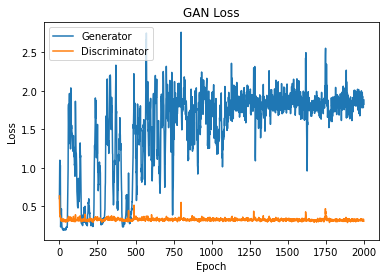

In [73]:
#mod8 - flipping + smoothing gen, smoothing both for disc, lr 0.0001 disc, 0.001 gen
plot_loss(all_gen_loss_mod,all_disc_loss_mod)

####Plot Analysis

<li> The stable gan has much less variation in generator loss, which means it is now able to fool the discriminator much better. 
<li> The discriminator loss jumps up frequently, showing that the generator was able to fool it more this time.
<li> The generator loss is also much lower and closer to the discriminator loss

In [0]:
generator_mod = build_generator_mod()
generator_mod.load_weights('/content/drive/My Drive/DLAS5/generator_mod8')

In [0]:
for i in range(1,5):
  noise = sample_noise_mod()
  grid = generator_mod.predict(noise)
  save_samples(grid,i,save_at='final_mod8')

### Analysis 
Repeat the above analysis and mention changes you observed in terms of training and quality of fake images <br>

 The images generated from the unstable GAN lacked quality and variation whereas the stable GAN produced much better results after the following optimizations were applied:
*   Using a learning rate of 0.0001 for the discriminator and 0.001 for the generator.
*   Smoothing the labels passed to the discriminator and flipping the labels of the generator with a 5% probability. Since the unstable gan had little to no variation(Mode Collapse), flipping the labels helped the generator learn more diverse features
*  Normalizing the training images helped the gan learn features much more clearly than before.

These modifications in the training loop resulted in the generator being able to produce recognizable emojis with diverse features and low level of duplication. The optimizations also decreased the generator loss and variation by a significant margin. No failure modes were encountered in this training

In [0]:
#interpolating samples with vector math
noise1 = sample_noise_mod()
grid1 = generator_mod.predict(noise)
save_samples(grid1,1,save_at='vector_gen')

noise2 = sample_noise_mod()
grid2 = generator_mod.predict(noise2)
save_samples(grid2,2,save_at='vector_gen')

noise3 = sample_noise_mod()
grid3 = generator_mod.predict(noise3)
save_samples(grid3,3,save_at='vector_gen')


In [0]:
grid4 = generator_mod.predict(noise1 - noise2 + noise3)
save_samples(grid4,4,save_at='vector_gen')

The interpolation unfortunately does not produce results as expected. This is perhaps because the samples do not have very clearly defined features.

## BONUS - 10%
The current training set was a subset of the actual emojis dataset. In the filtering process, most inanimate objects were removed and the focus was on front-facing emojis. Train the model over the full dataset or a subset of your choice and repeat the above analysis